In [24]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [32]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from geopy.distance import distance

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


# 2. Load Data

In [33]:
train = pd.read_csv('../Dataset/train.csv').dropna()
test = pd.read_csv('../Dataset/test.csv').dropna()

# 3. Initial Analysis

### 3.1. Metadata

In [36]:
train.head(5)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0.0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,(min) 30


In [35]:
test.head(5)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City
1,0x3474,BANGRES15DEL01,28.0,4.6,12.975377,77.696664,13.085377,77.806664,29-03-2022,20:30:00,20:35:00,conditions Windy,Jam,0,Snack,motorcycle,1.0,No,Metropolitian
2,0x9420,JAPRES09DEL03,23.0,4.5,26.911378,75.789034,27.001378,75.879034,10-03-2022,19:35:00,19:45:00,conditions Stormy,Jam,0,Drinks,motorcycle,1.0,No,Metropolitian
3,0x72ee,JAPRES07DEL03,21.0,4.8,26.766536,75.837333,26.856536,75.927333,02-04-2022,17:15:00,17:20:00,conditions Fog,Medium,1,Meal,scooter,1.0,No,Metropolitian
4,0xa759,CHENRES19DEL01,31.0,4.6,12.986047,80.218114,13.096047,80.328114,27-03-2022,18:25:00,18:40:00,conditions Sunny,Medium,2,Drinks,scooter,1.0,No,Metropolitian
5,0xc4af,GOARES04DEL01,26.0,4.7,15.569600,73.742294,15.579600,73.752294,15-02-2022,09:45:00,09:55:00,conditions Fog,Low,0,Drinks,motorcycle,1.0,No,Metropolitian


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41368 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           41368 non-null  object 
 1   Delivery_person_ID           41368 non-null  object 
 2   Delivery_person_Age          41368 non-null  float64
 3   Delivery_person_Ratings      41368 non-null  float64
 4   Restaurant_latitude          41368 non-null  float64
 5   Restaurant_longitude         41368 non-null  float64
 6   Delivery_location_latitude   41368 non-null  float64
 7   Delivery_location_longitude  41368 non-null  float64
 8   Order_Date                   41368 non-null  object 
 9   Time_Orderd                  41368 non-null  object 
 10  Time_Order_picked            41368 non-null  object 
 11  Weatherconditions            41368 non-null  object 
 12  Road_traffic_density         41368 non-null  object 
 13  Vehicle_conditio

In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10291 entries, 1 to 11398
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           10291 non-null  object 
 1   Delivery_person_ID           10291 non-null  object 
 2   Delivery_person_Age          10291 non-null  float64
 3   Delivery_person_Ratings      10291 non-null  float64
 4   Restaurant_latitude          10291 non-null  float64
 5   Restaurant_longitude         10291 non-null  float64
 6   Delivery_location_latitude   10291 non-null  float64
 7   Delivery_location_longitude  10291 non-null  float64
 8   Order_Date                   10291 non-null  object 
 9   Time_Orderd                  10291 non-null  object 
 10  Time_Order_picked            10291 non-null  object 
 11  Weatherconditions            10291 non-null  object 
 12  Road_traffic_density         10291 non-null  object 
 13  Vehicle_conditio

In [39]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Delivery_person_Age,41368.0,29.610013,5.764152,20.000000,25.000000,30.000000,35.000000,39.000000
Delivery_person_Ratings,41368.0,4.633209,0.315861,2.500000,4.500000,4.700000,4.900000,5.000000
Restaurant_latitude,41368.0,17.254366,7.691357,-30.902872,12.933298,18.554382,22.732225,30.914057
Restaurant_longitude,41368.0,70.777471,21.122080,0.000000,73.170283,75.898497,78.046106,88.433452
Delivery_location_latitude,41368.0,17.472437,7.337077,0.010000,12.989096,18.636258,22.785536,31.054057
Delivery_location_longitude,41368.0,70.841351,21.122283,0.010000,73.279083,76.002471,78.107097,88.563452
Vehicle_condition,41368.0,0.995891,0.817995,0.000000,0.000000,1.000000,2.000000,2.000000
multiple_deliveries,41368.0,0.748139,0.572934,0.000000,0.000000,1.000000,1.000000,3.000000


In [40]:
print(train.isnull().sum())
print('\n')
print(test.isnull().sum())

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weatherconditions              0
Road_traffic_density           0
Vehicle_condition              0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
Time_taken(min)                0
dtype: int64


ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                 

### 3.2. Columns Processing

In [41]:
train['Time_taken(min)'] = [time.split(' ')[1] for time in train['Time_taken(min)']]
train['Time_taken(min)'] = train['Time_taken(min)'].astype('int8')

In [42]:
numerical_columns = [column_name for column_name in train.columns if train[column_name].dtype != 'object']
numerical_columns_test = [column_name for column_name in test.columns if test[column_name].dtype != 'object']

categorical_columns = [column_name for column_name in train.columns if train[column_name].dtype == 'object']
categorical_columns_test = [column_name for column_name in test.columns if test[column_name].dtype == 'object']

print(f'Numerical Columns Train   : {numerical_columns}')
print(f'Numerical Columns Test    : {numerical_columns_test}')
print(f'Categorical Columns Train : {categorical_columns}')
print(f'Categorical Columns Train : {categorical_columns_test}')

Numerical Columns Train   : ['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Vehicle_condition', 'multiple_deliveries', 'Time_taken(min)']
Numerical Columns Test    : ['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Vehicle_condition', 'multiple_deliveries']
Categorical Columns Train : ['ID', 'Delivery_person_ID', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 'Festival', 'City']
Categorical Columns Train : ['ID', 'Delivery_person_ID', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 'Festival', 'City']


In [43]:
le =  LabelEncoder()

train['Weatherconditions'] = le.fit_transform(train['Weatherconditions'])
train['Road_traffic_density'] = le.fit_transform(train['Road_traffic_density'])
train['Type_of_order'] = le.fit_transform(train['Type_of_order'])
train['Type_of_vehicle'] = le.fit_transform(train['Type_of_vehicle'])
train['Festival'] = le.fit_transform(train['Festival'])
train['City'] = le.fit_transform(train['City'])

test['Weatherconditions'] = le.fit_transform(test['Weatherconditions'])
test['Road_traffic_density'] = le.fit_transform(test['Road_traffic_density'])
test['Type_of_order'] = le.fit_transform(test['Type_of_order'])
test['Type_of_vehicle'] = le.fit_transform(test['Type_of_vehicle'])
test['Festival'] = le.fit_transform(test['Festival'])
test['City'] = le.fit_transform(test['City'])

In [44]:
# def get_distance(row):
#     place1 = (row['Restaurant_latitude'], row['Restaurant_longitude'])
#     place2 = (row['Delivery_location_latitude'], row['Delivery_location_longitude'])
#     return distance(place1, place2).km

# train['distance_km'] = train.apply(get_distance, axis=1)

# Set the earth's radius (in kilometers)
R = 6371

# Convert degrees to radians
def deg_to_rad(degrees):
    return degrees * (np.pi/180)

# Function to calculate the distance between two points using the haversine formula
def distcalculate(lat1, lon1, lat2, lon2):
    d_lat = deg_to_rad(lat2 - lat1)
    d_lon = deg_to_rad(lon2 - lon1)
    a = np.sin(d_lat/2)**2 + np.cos(deg_to_rad(lat1)) * np.cos(deg_to_rad(lat2)) * np.sin(d_lon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Calculate the distance between each pair of points
train['distance'] = distcalculate(train['Restaurant_latitude'], 
                                    train['Restaurant_longitude'], 
                                    train['Delivery_location_latitude'], 
                                    train['Delivery_location_longitude'])

test['distance'] = distcalculate(test['Restaurant_latitude'], 
                                test['Restaurant_longitude'], 
                                test['Delivery_location_latitude'], 
                                test['Delivery_location_longitude'])

In [45]:
drop_colums = ['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'ID', 'Delivery_person_ID', 'Order_Date', 'Time_Orderd', 'Time_Order_picked']

train = train.drop(columns = drop_colums)
test = test.drop(columns = drop_colums)

In [46]:
train

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),distance
0,37.0,4.9,4,0,2,3,1,0.0,0,2,24,3.025149
1,34.0,4.5,3,1,2,3,2,1.0,0,0,33,20.183530
2,23.0,4.4,2,2,0,1,1,1.0,0,2,26,1.552758
3,38.0,4.7,4,3,0,0,1,1.0,0,0,21,7.790401
4,32.0,4.6,0,0,1,3,2,1.0,0,0,30,6.210138
...,...,...,...,...,...,...,...,...,...,...,...,...
45588,30.0,4.8,5,0,1,2,1,0.0,0,0,32,1.489846
45589,21.0,4.6,5,1,0,0,1,1.0,0,0,36,11.007735
45590,30.0,4.9,0,2,1,1,2,0.0,0,0,16,4.657195
45591,20.0,4.7,0,0,0,3,1,1.0,0,0,26,6.232393


# 4. EDA

Text(0.5, 1.0, 'Correlation Matrix')

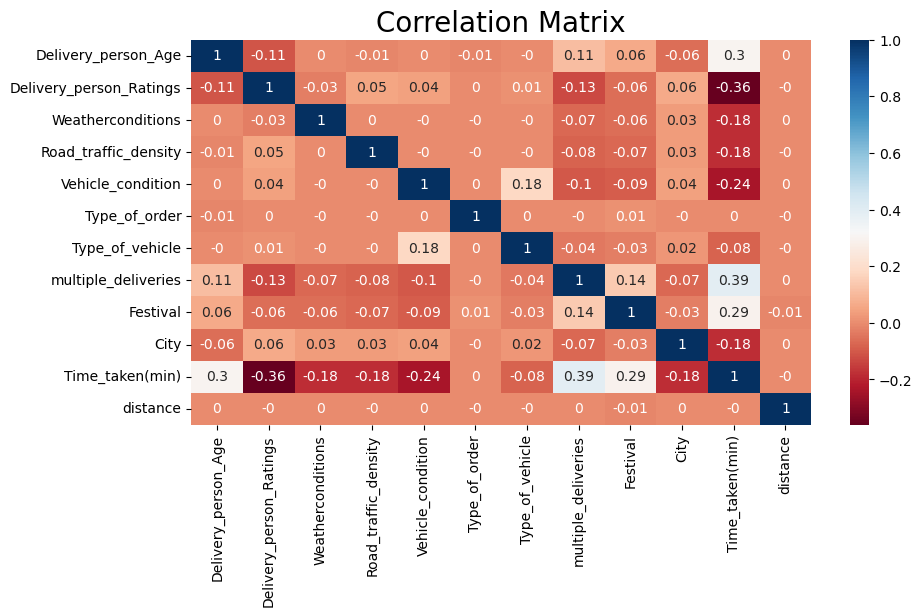

In [50]:
corr_data = train.corr().round(2)

plt.figure(figsize=(10, 5))
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 5. Regression Algoritms

In [51]:
# features = numerical_columns[:14]

X = train.drop(columns=['Time_taken(min)'])
Y = train['Time_taken(min)']

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(33094, 11)
(8274, 11)


In [67]:
adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradientBoosting = HistGradientBoostingRegressor()
XGB = XGBRegressor(n_jobs = -1)
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)

model = StackingRegressor([
    ('bagging', bagging),
    ('extraTrees', extraTrees),
    ('randomforest', randomForest),
    ('decisionTree', decisionTree),
    # ('adaboost', adaboost),
    # ('gradient', gradient),
    # ('histGradientBoosting', histGradientBoosting),
    # ('XGB', XGB),
    # ('knn', knn),

], n_jobs=-1)

In [68]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('bagging', BaggingRegressor(n_jobs=-1)),
                              ('extraTrees',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42)),
                              ('randomforest',
                               RandomForestRegressor(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                              ('decisionTree',
                               DecisionTreeRegressor(max_depth=100,
                                                     random_state=42))],
                  n_jobs=-1)

In [71]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

Train Score        : 98.04 %
Test Score         : 82.86 %
R Squared Error    : 0.83
Mean Squared Error : 15.04


In [55]:
train_predictions = model.predict(X_test).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
train_results

,Train Predictions,Actuals,Diff
38363,14.791789,17,2.208211
11693,19.153088,22,2.846912
45310,39.198656,32,7.198656
10087,22.513736,22,0.513736
5560,39.767762,41,1.232238
...,...,...,...
37221,16.000154,11,5.000154
4625,31.628197,31,0.628197
40566,19.813711,17,2.813711
26904,22.252036,28,5.747964


In [74]:
print(train_results['Diff'].mean())

3.0915673871853633


In [75]:
train_df = train.copy()

train_x = train_df.drop(columns=['Time_taken(min)']).values
train_predictions = np.round(model.predict(train_x).flatten(), 2)

train_df['Prediction'] = train_predictions
train_df.head(5)

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),distance,Prediction
0,37.0,4.9,4,0,2,3,1,0.0,0,2,24,3.025149,22.39
1,34.0,4.5,3,1,2,3,2,1.0,0,0,33,20.183530,25.43
2,23.0,4.4,2,2,0,1,1,1.0,0,2,26,1.552758,26.05
3,38.0,4.7,4,3,0,0,1,1.0,0,0,21,7.790401,25.50
4,32.0,4.6,0,0,1,3,2,1.0,0,0,30,6.210138,18.04


In [76]:
test_df = test.copy()

test_x = test_df.drop(columns=[]).values
train_predictions = np.round(model.predict(test_x).flatten(), 2)

test_df['Prediction'] = train_predictions
test_df.head(5)

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,distance,Prediction
1,28.0,4.6,5,1,0,3,1,1.0,0,0,17.076617,25.71
2,23.0,4.5,3,1,0,1,1,1.0,0,0,13.406029,25.75
3,21.0,4.8,1,3,1,2,2,1.0,0,0,13.413644,26.48
4,31.0,4.6,4,3,2,1,2,1.0,0,0,17.076259,25.57
5,26.0,4.7,1,2,0,1,1,1.0,0,0,1.543933,25.32


# 6. Neural Network

In [87]:
X = train.drop(columns=['Time_taken(min)'])
Y = train['Time_taken(min)']

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True)
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
X_val = scalar.fit_transform(X_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29040, 11)
(8191, 11)
(4137, 11)


In [104]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

model = DNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.00001)

# model.compile(loss='mse', optimizer=opt, metrics=['mse'])
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 1024)              12288     
                                                                 
 dense_21 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_22 (Dense)            (None, 128)               131200    
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,193,217
Trainable params: 1,193,217
Non-trainable params: 0
_________________________________________________________________


In [107]:
num_epoch = 100
batch_size = 32

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch,
                    validation_data = [X_val, y_val], shuffle=False, verbose = 1,
                    callbacks = [reduce_lr]
                    )

Epoch 1/100
908/908 [==============================] - 3s 3ms/step - loss: 19.8875 - val_loss: 22.3444 - lr: 1.0000e-05
Epoch 2/100
908/908 [==============================] - 2s 3ms/step - loss: 19.8379 - val_loss: 22.3086 - lr: 1.0000e-05
Epoch 3/100
908/908 [==============================] - 2s 3ms/step - loss: 19.7887 - val_loss: 22.2740 - lr: 1.0000e-05
Epoch 4/100
908/908 [==============================] - 2s 3ms/step - loss: 19.7399 - val_loss: 22.2389 - lr: 1.0000e-05
Epoch 5/100
908/908 [==============================] - 2s 3ms/step - loss: 19.6918 - val_loss: 22.2052 - lr: 1.0000e-05
Epoch 6/100
908/908 [==============================] - 2s 3ms/step - loss: 19.6438 - val_loss: 22.1711 - lr: 1.0000e-05
Epoch 7/100
908/908 [==============================] - 2s 3ms/step - loss: 19.5964 - val_loss: 22.1375 - lr: 1.0000e-05
Epoch 8/100
908/908 [==============================] - 2s 3ms/step - loss: 19.5494 - val_loss: 22.1042 - lr: 1.0000e-05
Epoch 9/100
908/908 [===================

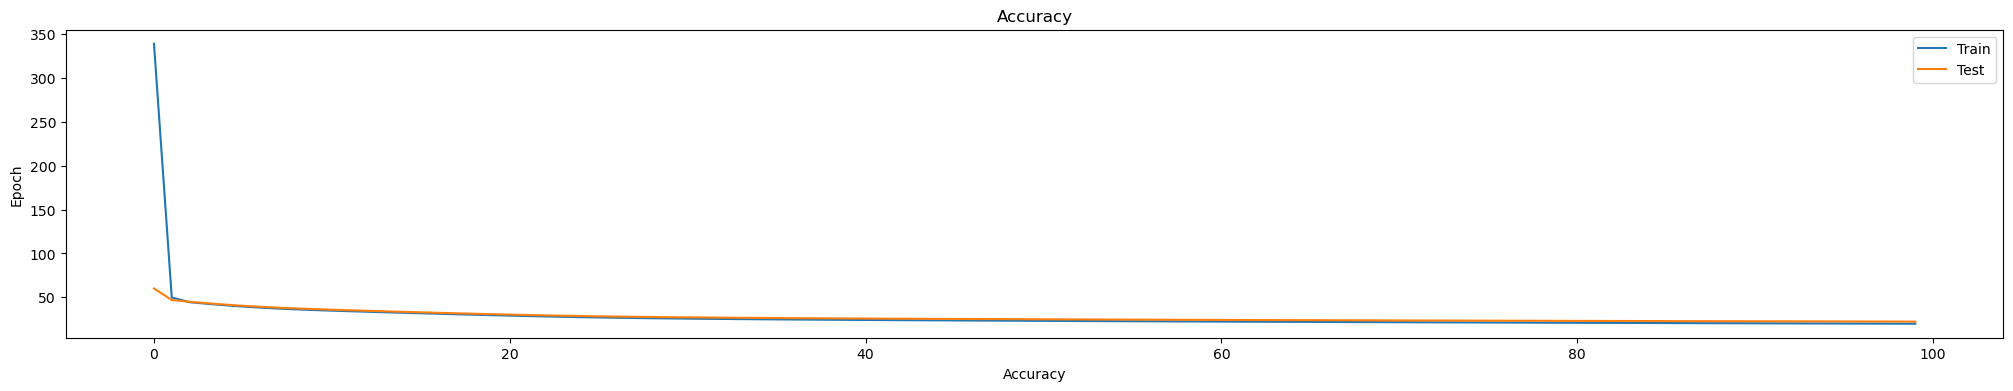

In [106]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [102]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

R Squared Error    : 0.78
Mean Squared Error : 19.43


In [82]:
train_predictions = model.predict(X_test).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
train_results

256/256 [==============================] - 1s 2ms/step


,Train Predictions,Actuals,Diff
6401,22.714827,21,1.714827
16327,16.682602,15,1.682602
33028,37.537724,38,0.462276
2122,30.013916,33,2.986084
38500,33.557865,33,0.557865
...,...,...,...
45552,13.019119,17,3.980881
20495,40.975517,43,2.024483
3705,19.759230,26,6.240770
34728,25.904932,27,1.095068


In [83]:
print(train_results['Diff'].mean())

3.6437907


In [85]:
pred_df = test.copy()

x_test = pred_df.drop(columns=['ID', 'Delivery_person_ID', 'Order_Date', 'Time_Orderd', 'Time_Order_picked'])
train_predictions = np.rint(model.predict(x_test).flatten())

pred_df['Prediction'] = train_predictions
pred_df


322/322 [==============================] - 1s 2ms/step


,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,distance,Prediction
1,0x3474,BANGRES15DEL01,28.0,4.6,29-03-2022,20:30:00,20:35:00,5,1,0,3,1,1.0,0,0,17.076617,137.0
2,0x9420,JAPRES09DEL03,23.0,4.5,10-03-2022,19:35:00,19:45:00,3,1,0,1,1,1.0,0,0,13.406029,112.0
3,0x72ee,JAPRES07DEL03,21.0,4.8,02-04-2022,17:15:00,17:20:00,1,3,1,2,2,1.0,0,0,13.413644,99.0
4,0xa759,CHENRES19DEL01,31.0,4.6,27-03-2022,18:25:00,18:40:00,4,3,2,1,2,1.0,0,0,17.076259,134.0
5,0xc4af,GOARES04DEL01,26.0,4.7,15-02-2022,09:45:00,09:55:00,1,2,0,1,1,1.0,0,0,1.543933,119.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11393,0xe240,BHPRES07DEL01,31.0,4.7,13-02-2022,11:00:00,11:10:00,5,2,2,3,2,1.0,0,0,1.572534,110.0
11394,0x6909,JAPRES01DEL01,35.0,4.6,27-03-2022,21:35:00,21:45:00,4,1,1,3,2,1.0,0,0,16.384901,152.0
11395,0x443b,JAPRES11DEL01,33.0,4.9,11-03-2022,11:40:00,11:45:00,2,0,1,1,2,1.0,0,0,1.489842,145.0
11397,0x22d4,VADRES03DEL02,27.0,4.7,06-03-2022,18:35:00,18:40:00,2,3,0,2,1,0.0,0,0,19.687777,136.0
